In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv")

In [4]:
df.shape

(11914, 16)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

# Data preparation
* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average
* Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. 
* Use [train_test_split] function for that with [random_state=1]

In [7]:
columns_use = ['Make','Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type',
                  'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']

In [8]:
df = df[columns_use]
df.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [9]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

for col in df.describe(exclude='number').columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')
    
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,46135
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,40650
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,36350
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,29450
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,34500


In [10]:
df.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [11]:
df.fillna(0, inplace=True)
df.isnull().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64

Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average

In [12]:
price_mean = df.msrp.mean()
price_mean

40594.737032063116

In [13]:
df['above_average'] = df.msrp.apply(lambda x: 1 if x > price_mean else 0)

In [14]:
df = df.drop(columns='msrp')
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,1
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,0
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,0
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,0


In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train.shape, df_val.shape, df_test.shape

((7148, 10), (2383, 10), (2383, 10))

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = df_train.above_average
y_val = df_val.above_average
y_test = df_test.above_average

In [18]:
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

# Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables. Let's do that

* For each numerical variable, use it as score and compute AUC with the above_average variable
* Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

#### engine_hp
engine_cylinders
highway_mpg
city_mpg

In [19]:
auc_result = []

for col in df_train.describe().columns:
    res = roc_auc_score(y_train, df_train[col])
    
    if res < 0.5:
        res = roc_auc_score(y_train, -df_train[col])
    auc_result.append((col, res))
df_auc_res = pd.DataFrame(auc_result, columns=['column', 'auc_score'])
df_auc_res.sort_values('auc_score', ascending=False)

,column,auc_score
1,engine_hp,0.917103
2,engine_cylinders,0.766116
0,year,0.687551
4,city_mpg,0.673424
3,highway_mpg,0.633059


# Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

0.678
0.779
0.878
### 0.979

In [21]:
dv = DictVectorizer()
X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_train.shape

(7148, 953)

In [22]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [23]:
X_val = dv.transform(df_val.to_dict(orient='records'))
X_val.shape

(2383, 953)

In [24]:
y_val_pred = model.predict_proba(X_val)[:, 1]
y_val_pred.shape, y_val_pred.mean()

((2383,), 0.2778594348388117)

In [25]:
roc_auc_score(y_val, y_val_pred).round(4)

0.9761

# Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

0.28
#### 0.48
0.68
0.88

In [26]:
thresholds = np.linspace(0, 1, round(1/0.01 + 1))

Curves intersect at approx: t=0.48


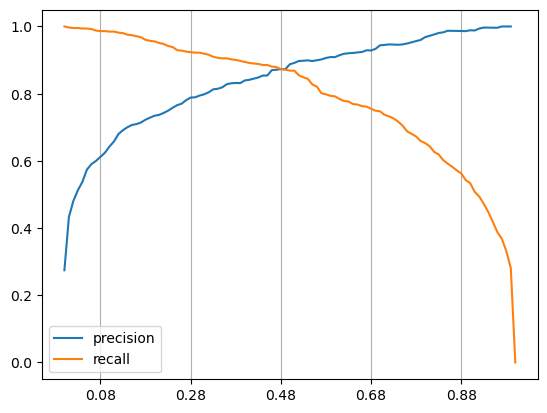

In [27]:
scores = []

pt_intersect = float('inf')
threshold_intersect = None

for t in thresholds:
    act_p = (y_val == 1)
    act_n = (y_val == 0)
    
    pred_p = (y_val_pred >= t)
    pred_n = (y_val_pred < t)
    
    tp = (act_p & pred_p).sum()
    tn = (act_n & pred_n).sum()
    fp = (act_n & pred_p).sum()
    fn = (act_p & pred_n).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    scores.append((t, tp, tn, fp, fn, precision, recall))
    
    if abs(recall - precision) < pt_intersect:
        pt_intersect = abs(recall - precision)
        threshold_intersect = t
        
df_scores = pd.DataFrame(
    scores, 
    columns=[
        't', 
        'tp', 'tn', 'fp', 'fn',
        'p', 'r'
    ],
    index=thresholds
)

plt.plot(df_scores.t, df_scores.p, label='precision');
plt.plot(df_scores.t, df_scores.r, label='recall');
plt.xticks(np.linspace(0.08, 0.88, 5));
plt.grid(axis='x');
plt.legend();

print(f'Curves intersect at approx: t={threshold_intersect:.2f}')

# Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

 
Where 
 is precision and 
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

0.12
0.32
### 0.52
0.72

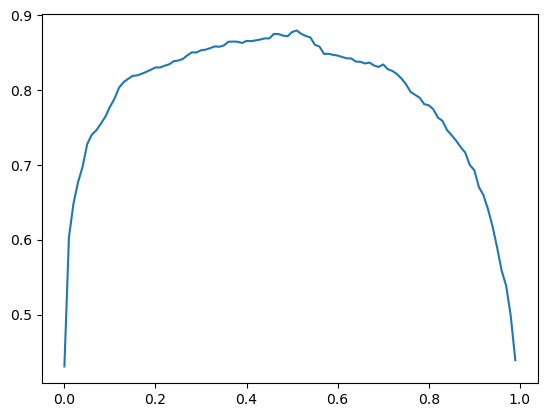

In [28]:
df_scores['F1'] = 2 * (df_scores.p * df_scores.r) / (df_scores.p + df_scores.r)

plt.plot(df_scores.t, df_scores.F1);

In [30]:
df_scores.sort_values('F1', ascending=False).head()

,t,tp,tn,fp,fn,p,r,F1
0.51,0.51,568,1660,69,86,0.891680,0.868502,0.879938
0.50,0.50,568,1657,72,86,0.887500,0.868502,0.877898
0.52,0.52,559,1665,64,95,0.897271,0.854740,0.875489
0.46,0.46,576,1643,86,78,0.870091,0.880734,0.875380
0.47,0.47,575,1644,85,79,0.871212,0.879205,0.875190


# Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard devidation of the scores across different folds?

### 0.003
0.030
0.090
0.140

In [ ]:
def train(df_train, y_train, C=1):
    dict = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dict)
    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)
    return dv, model
def predict(df, dv, model):
    dict = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dict)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred
from sklearn.model_selection import KFold
kfold=KFold(n_splits=5, shuffle=True, random_state=1)
score = []
for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
    y_train = df_train.above_average
    y_val = df_val.above_average
    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)
    auc = roc_auc_score(y_val, y_pred)
    score.append(auc)

print((np.mean(score), np.std(score)))
#close to 0.003
(0.9793078945520477, 0.002060199182252492)     

# Question 6: Hyperparemeter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 0.5, 10]
Initialize KFold with the same parameters as previously
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

0.01
0.1
0.5
### 10
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [ ]:
for C in [0.01, 0.1, 0.5, 10]:
    scores = kfold_scores(df_train_full, C=C)
    print(f'{C=:5.2f}, mean={scores.mean():.3f}, std={scores.std():.3f}')